Usando dispositivo: cuda


/tmp/ipykernel_3336031/583042197.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model = ConvolutionalVAE(**VAE_PARAMS); vae_model.load_state_dict(torch.load(FOLD_

Modelo VAE cargado.
Pipeline de Clasificador cargado.
Parámetros de Normalización del VAE cargados.
Índices de Test del Fold cargados (37 sujetos).
Orden de ROIs y mapeo a redes cargado (131 ROIs).
Etiquetas y colores de ROIs cargados.


Calculando saliencia de sujetos: 100%|██████████| 37/37 [00:00<00:00, 43.73it/s]



Saliencia global de ROIs calculada promediando 37 sujetos.

--- RANKING DE IMPORTANCIA POR ROI INDIVIDUAL (GLOBAL) ---


,AAL3_Name,Yeo17_Network,Saliency_Score
0,CER7BR,Background/NonCortical,0.339025
1,P2R,Control_B,0.334613
2,P2L,Control_A,0.283399
3,HESCHLL,Somatomotor_B,0.240831
4,GRR,Limbic_B_OFC,0.228081
5,COBR,Limbic_B_OFC,0.226533
6,T1AR,Limbic_A_TempPole,0.221951
7,CIPR,DefaultMode_DorsalMedial,0.219674
8,PARA_HIPPOR,Limbic_A_TempPole,0.218030
9,T2AR,Limbic_A_TempPole,0.214909



Gráfico de ranking de ROIs guardado.


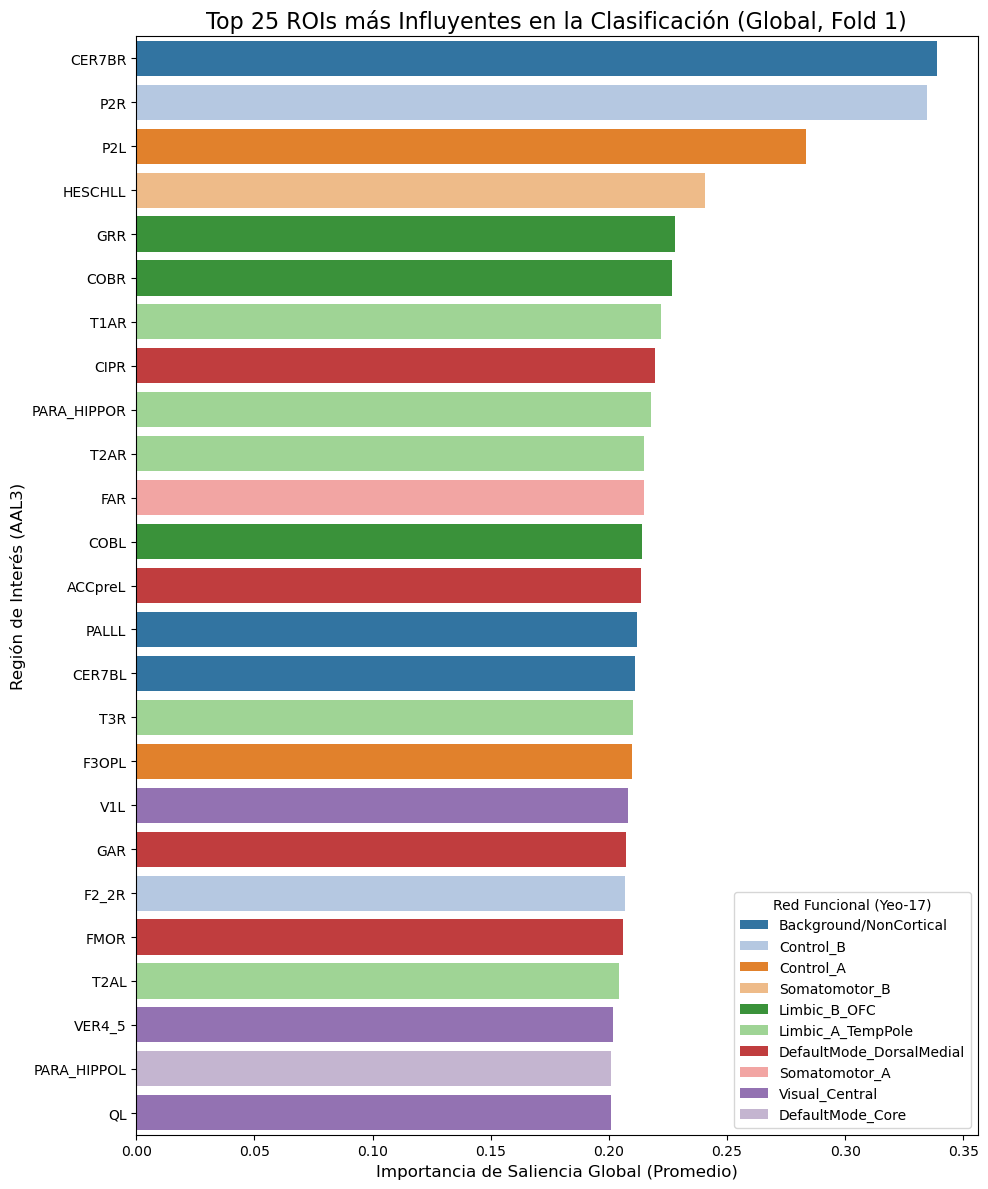


Generando visualizaciones cerebrales con Nilearn...
Imagen NIfTI de saliencia creada con el atlas AAL3 correcto.


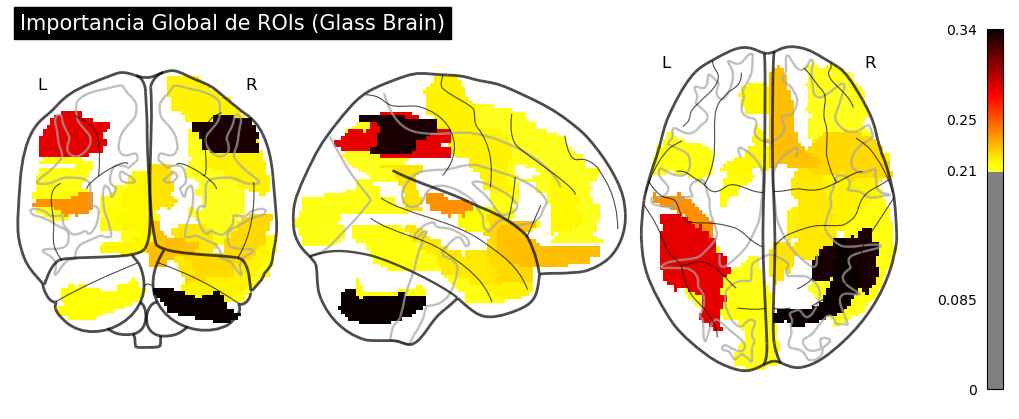

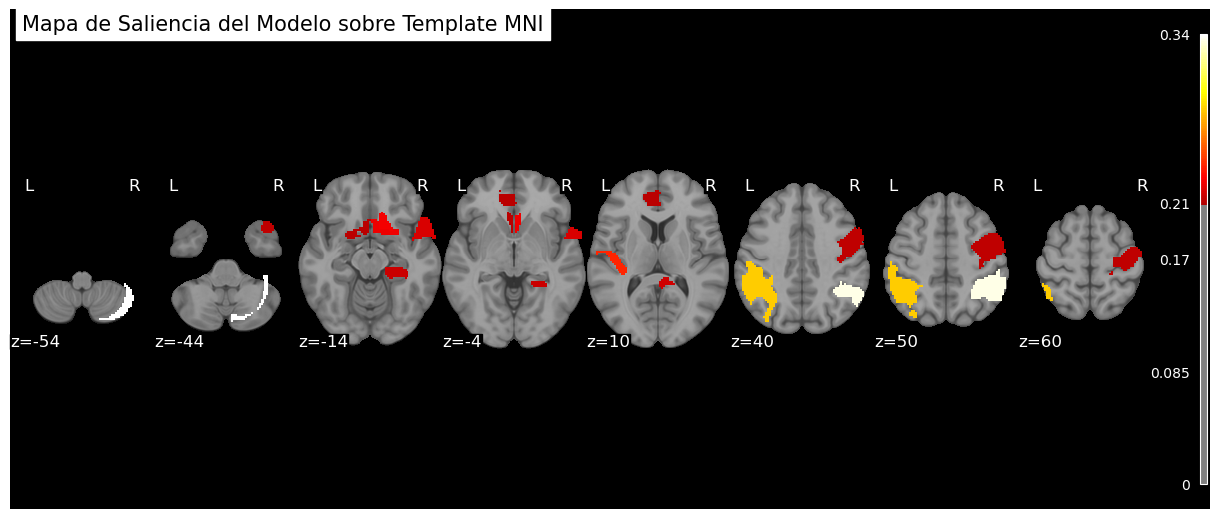

In [1]:
# -*- coding: utf-8 -*-
# # Análisis de Interpretabilidad Definitivo: Importancia de ROIs
# 
# **Objetivo**: Identificar, rankear y visualizar los ROIs más influyentes para la clasificación CN vs AD,
# utilizando los artefactos guardados y el atlas anatómico correcto para máxima precisión.

# ## Paso 1: Carga Completa de Artefactos del Fold 1
import torch
import torch.nn as nn
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from typing import Tuple, Union, List
from nilearn import datasets, plotting, image

# --- Definición de la Clase ConvolutionalVAE ---
# (Se asume la definición completa de la clase VAE con GroupNorm, como en el prompt anterior)
class ConvolutionalVAE(nn.Module):
    def __init__(
        self, input_channels: int = 6, latent_dim: int = 128, image_size: int = 131,
        final_activation: str = "tanh", intermediate_fc_dim_config: Union[int, str] = "0",
        dropout_rate: float = 0.2, use_layernorm_fc: bool = False,
        num_conv_layers_encoder: int = 4, decoder_type: str = "convtranspose", num_groups: int = 8
    ) -> None:
        super().__init__()
        if num_conv_layers_encoder not in {3, 4}: raise ValueError("num_conv_layers_encoder must be 3 or 4.")
        if decoder_type not in {"upsample_conv", "convtranspose"}: raise ValueError("decoder_type must be 'upsample_conv' or 'convtranspose'.")
        self.latent_dim = latent_dim; self.num_groups = num_groups; encoder_layers: List[nn.Module] = []; curr_ch = input_channels
        base_conv_ch = [max(16, input_channels * 2), max(32, input_channels * 4), max(64, input_channels * 8), max(128, input_channels * 16)]
        conv_ch_enc = [min(c, 256) for c in base_conv_ch][:num_conv_layers_encoder]
        kernels = [7, 5, 5, 3][:num_conv_layers_encoder]; paddings = [1, 1, 1, 1][:num_conv_layers_encoder]; strides = [2, 2, 2, 2][:num_conv_layers_encoder]
        spatial_dims = [image_size]; dim = image_size
        for k, p, s, ch_out in zip(kernels, paddings, strides, conv_ch_enc):
            encoder_layers += [
                nn.Conv2d(curr_ch, ch_out, kernel_size=k, stride=s, padding=p),
                nn.GELU(), nn.GroupNorm(self.num_groups, ch_out), nn.Dropout2d(p=dropout_rate),
            ]; curr_ch = ch_out; dim = ((dim + 2 * p - k) // s) + 1; spatial_dims.append(dim)
        self.encoder_conv = nn.Sequential(*encoder_layers)
        self.final_conv_ch = curr_ch; self.final_spatial_dim = dim; flat_size = curr_ch * dim * dim
        self.intermediate_fc_dim = self._resolve_intermediate_fc(intermediate_fc_dim_config, flat_size)
        if self.intermediate_fc_dim:
            fc_layers = [nn.Linear(flat_size, self.intermediate_fc_dim)]
            if use_layernorm_fc: fc_layers.append(nn.LayerNorm(self.intermediate_fc_dim))
            fc_layers += [nn.GELU(), nn.BatchNorm1d(self.intermediate_fc_dim), nn.Dropout(p=dropout_rate)]
            self.encoder_fc_intermediate = nn.Sequential(*fc_layers); mu_logvar_in = self.intermediate_fc_dim
        else: self.encoder_fc_intermediate = nn.Identity(); mu_logvar_in = flat_size
        self.fc_mu = nn.Linear(mu_logvar_in, latent_dim); self.fc_logvar = nn.Linear(mu_logvar_in, latent_dim)
        if self.intermediate_fc_dim:
            dec_fc_layers = [nn.Linear(latent_dim, self.intermediate_fc_dim)]
            if use_layernorm_fc: dec_fc_layers.append(nn.LayerNorm(self.intermediate_fc_dim))
            dec_fc_layers += [nn.GELU(), nn.BatchNorm1d(self.intermediate_fc_dim), nn.Dropout(p=dropout_rate)]
            self.decoder_fc_intermediate = nn.Sequential(*dec_fc_layers); dec_fc_out = self.intermediate_fc_dim
        else: self.decoder_fc_intermediate = nn.Identity(); dec_fc_out = latent_dim
        self.decoder_fc_to_conv = nn.Linear(dec_fc_out, flat_size); decoder_layers: List[nn.Module] = []
        curr_ch_dec = self.final_conv_ch; target_conv_t_channels = conv_ch_enc[-2::-1] + [input_channels]
        decoder_kernels = kernels[::-1]; decoder_paddings = paddings[::-1]; decoder_strides = strides[::-1]; output_paddings: List[int] = []
        tmp_dim = self.final_spatial_dim
        for i in range(len(decoder_kernels)):
            k, s, p = decoder_kernels[i], decoder_strides[i], decoder_paddings[i]
            target_dim = spatial_dims[len(decoder_kernels) - 1 - i]; op = target_dim - ((tmp_dim - 1) * s - 2 * p + k)
            output_paddings.append(max(0, min(s - 1, op))); tmp_dim = (tmp_dim - 1) * s - 2 * p + k + op
        for i, ch_out in enumerate(target_conv_t_channels):
            decoder_layers += [nn.ConvTranspose2d(curr_ch_dec, ch_out, kernel_size=decoder_kernels[i], stride=decoder_strides[i], padding=decoder_paddings[i], output_padding=output_paddings[i]), nn.GELU() if i < len(target_conv_t_channels) - 1 else nn.Identity()]
            if i < len(target_conv_t_channels) - 1: decoder_layers += [nn.GroupNorm(self.num_groups, ch_out), nn.Dropout2d(p=dropout_rate)]
            curr_ch_dec = ch_out
        if final_activation == "sigmoid": decoder_layers.append(nn.Sigmoid())
        elif final_activation == "tanh": decoder_layers.append(nn.Tanh())
        self.decoder_conv = nn.Sequential(*decoder_layers)
    def _resolve_intermediate_fc(self, cfg: Union[int, str], flat_size: int) -> int:
        if cfg == "0" or cfg == 0: return 0
        if isinstance(cfg, str):
            cfg = cfg.lower()
            if cfg == "half": return flat_size // 2
            if cfg == "quarter": return flat_size // 4
            try: return int(cfg)
            except ValueError: return 0
        return int(cfg)
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.encoder_conv(x); h = h.view(h.size(0), -1); h = self.encoder_fc_intermediate(h)
        return self.fc_mu(h), self.fc_logvar(h)
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x); z = self.reparameterize(mu, logvar); recon_x = self.decode(z)
        if recon_x.shape != x.shape: recon_x = nn.functional.interpolate(recon_x, size=(x.shape[2], x.shape[3]), mode="bilinear", align_corners=False)
        return recon_x, mu, logvar, z

# (Funciones de ayuda de normalización)
def apply_normalization_params(data_tensor_subset: np.ndarray, norm_params_per_channel_list: list) -> np.ndarray:
    num_subjects, num_selected_channels, num_rois, _ = data_tensor_subset.shape; normalized_tensor_subset = data_tensor_subset.copy(); off_diag_mask = ~np.eye(num_rois, dtype=bool)
    for c_idx_selected in range(num_selected_channels):
        params = norm_params_per_channel_list[c_idx_selected]; mode = params.get('mode', 'zscore_offdiag')
        if params.get('no_scale', False): continue
        current_channel_data = data_tensor_subset[:, c_idx_selected, :, :]; scaled_channel_data_subset = current_channel_data.copy()
        if off_diag_mask.any():
            if mode == 'zscore_offdiag':
                if params['std'] > 1e-9: scaled_channel_data_subset[:, off_diag_mask] = (current_channel_data[:, off_diag_mask] - params['mean']) / params['std']
        normalized_tensor_subset[:, c_idx_selected, :, :] = scaled_channel_data_subset
    return normalized_tensor_subset
def normalize_inter_channel_fold(data_tensor: np.ndarray, train_indices_in_fold: np.ndarray):
    _, num_selected_channels, num_rois, _ = data_tensor.shape; norm_params_per_channel_list = []
    off_diag_mask = ~np.eye(num_rois, dtype=bool)
    for c_idx_selected in range(num_selected_channels):
        params = {'mode': 'zscore_offdiag'}
        channel_data_train_for_norm_params = data_tensor[train_indices_in_fold, c_idx_selected, :, :]
        all_off_diag_train_values = channel_data_train_for_norm_params[:, off_diag_mask].flatten()
        mean_val, std_val = np.mean(all_off_diag_train_values), np.std(all_off_diag_train_values)
        params.update({'mean': mean_val, 'std': std_val if std_val > 1e-9 else 1.0})
        norm_params_per_channel_list.append(params)
    return norm_params_per_channel_list

# --- Configuración de Rutas y Parámetros ---
OUTPUT_DIR = Path('./resultados_12_inter')
FOLD_DIR = OUTPUT_DIR / 'fold_1'
TENSOR_PATH = '/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz'
METADATA_PATH = '/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv'
MAPPING_PATH = './aal3_131_to_yeo17_mapping.csv'
AAL3_NIFTI_PATH = Path('/home/diego/Escritorio/limpio/AAL3v1.nii.gz') # <- Usamos el atlas correcto
ROI_LABELS_PATH = Path('./ROI_MNI_V7_vol.txt') # <- Usamos este para los 'color' index

CHANNELS_TO_USE = [1, 2, 5]; METADATA_FEATURES = ['Age', 'Sex']
VAE_PARAMS = {'input_channels': len(CHANNELS_TO_USE), 'latent_dim': 512, 'image_size': 131, 'final_activation': 'tanh', 'intermediate_fc_dim_config': 'quarter', 'dropout_rate': 0.2, 'use_layernorm_fc': False, 'num_conv_layers_encoder': 4, 'decoder_type': 'convtranspose', 'num_groups': 8}

# --- Carga de artefactos ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"Usando dispositivo: {device}")
vae_model = ConvolutionalVAE(**VAE_PARAMS); vae_model.load_state_dict(torch.load(FOLD_DIR / "vae_model_fold_1.pt", map_location=device)); vae_model.to(device); vae_model.eval(); print("Modelo VAE cargado.")
clf_pipeline = joblib.load(FOLD_DIR / "classifier_logreg_pipeline_fold_1.joblib"); print("Pipeline de Clasificador cargado.")
norm_params_fold1 = joblib.load(FOLD_DIR / "vae_norm_params.joblib"); print("Parámetros de Normalización del VAE cargados.")
test_indices = np.load(FOLD_DIR / "test_indices.npy"); print(f"Índices de Test del Fold cargados ({len(test_indices)} sujetos).")
roi_order_df = pd.read_csv(MAPPING_PATH); print(f"Orden de ROIs y mapeo a redes cargado ({len(roi_order_df)} ROIs).")
roi_labels_df = pd.read_csv(ROI_LABELS_PATH, sep='\t'); print("Etiquetas y colores de ROIs cargados.")

# Cargar datos completos
global_tensor_data = np.load(TENSOR_PATH)['global_tensor_data']; metadata_df = pd.read_csv(METADATA_PATH); metadata_df['SubjectID'] = metadata_df['SubjectID'].astype(str).str.strip(); subject_ids_tensor = np.load(TENSOR_PATH)['subject_ids'].astype(str); tensor_df = pd.DataFrame({'SubjectID': subject_ids_tensor, 'tensor_idx': np.arange(len(subject_ids_tensor))}); metadata_df_full = pd.merge(tensor_df, metadata_df, on='SubjectID', how='left')
cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN', 'AD'])].copy(); test_subject_df = cn_ad_df.iloc[test_indices]


# --- Modelo Wrapper y Cálculo de Saliencia ---
class FullPipelineWrapper(torch.nn.Module):
    def __init__(self, vae, clf_pipeline, device):
        super().__init__()
        self.vae = vae
        scaler = clf_pipeline.named_steps['scaler']
        logreg = clf_pipeline.named_steps['model']
        self.scaler_mean = torch.tensor(scaler.mean_, dtype=torch.float32, device=device)
        self.scaler_std  = torch.tensor(scaler.scale_, dtype=torch.float32, device=device)
        self.logreg_weights = torch.tensor(logreg.coef_, dtype=torch.float32, device=device)
        self.logreg_bias    = torch.tensor(logreg.intercept_, dtype=torch.float32, device=device)

    def forward(self, input_tensor, metadata_tensor):
        # ⬇️ Sólo dos valores: mu, logvar
        mu, _ = self.vae.encode(input_tensor)

        combined_features = torch.cat([mu, metadata_tensor], dim=1)
        scaled_features   = (combined_features - self.scaler_mean) / self.scaler_std
        logits            = torch.matmul(scaled_features, self.logreg_weights.T) + self.logreg_bias
        return torch.sigmoid(logits)

full_model = FullPipelineWrapper(vae_model, clf_pipeline, device).to(device)
full_model.eval()            # (opcional, pero recomendable)
all_roi_scores = []; ig = IntegratedGradients(full_model)
for _, subject_row in tqdm(test_subject_df.iterrows(), total=len(test_subject_df), desc="Calculando saliencia de sujetos"):
    subject_tensor_original = global_tensor_data[subject_row['tensor_idx'], :, :, :][CHANNELS_TO_USE, :, :][np.newaxis, ...]; subject_tensor_norm = apply_normalization_params(subject_tensor_original, norm_params_fold1)
    input_tensor = torch.from_numpy(subject_tensor_norm).float().to(device)
    age_val = float(subject_row['Age']); sex_val = 1.0 if subject_row['Sex'] == 'F' else 0.0
    metadata_np = np.array([[age_val, sex_val]], dtype=np.float32); metadata_tensor = torch.from_numpy(metadata_np).to(device)
    attributions, _ = ig.attribute(inputs=input_tensor, additional_forward_args=(metadata_tensor,), target=0, return_convergence_delta=True)
    saliency_map = attributions.cpu().detach().numpy().squeeze()
    roi_scores = np.abs(saliency_map).sum(axis=(0, 2)); all_roi_scores.append(roi_scores)
global_roi_saliency = np.mean(all_roi_scores, axis=0); print(f"\nSaliencia global de ROIs calculada promediando {len(all_roi_scores)} sujetos.")


# ## Paso 3: Ranking y Visualización de ROIs
roi_ranking_df = roi_order_df.copy() # Usamos el fichero de mapeo que tiene el orden y nombres correctos
roi_ranking_df['Saliency_Score'] = global_roi_saliency
roi_ranking_df = roi_ranking_df.sort_values(by='Saliency_Score', ascending=False).reset_index(drop=True)

print("\n--- RANKING DE IMPORTANCIA POR ROI INDIVIDUAL (GLOBAL) ---")
display(roi_ranking_df[['AAL3_Name', 'Yeo17_Network', 'Saliency_Score']].head(25))

# --- Visualización del Ranking ---
top_25_rois = roi_ranking_df.head(25)
fig, ax = plt.subplots(figsize=(10, 12))
sns.barplot(x='Saliency_Score', y='AAL3_Name', data=top_25_rois, hue='Yeo17_Network', dodge=False, palette='tab20', ax=ax)
ax.set_title('Top 25 ROIs más Influyentes en la Clasificación (Global, Fold 1)', fontsize=16)
ax.set_xlabel('Importancia de Saliencia Global (Promedio)', fontsize=12); ax.set_ylabel('Región de Interés (AAL3)', fontsize=12)
ax.legend(title='Red Funcional (Yeo-17)'); plt.tight_layout()
plt.savefig(OUTPUT_DIR / "top_25_roi_ranking_global.png"); print("\nGráfico de ranking de ROIs guardado.")
plt.show()

# ## Paso 4: Visualización Cerebral con el Atlas Correcto (AAL3)
print("\nGenerando visualizaciones cerebrales con Nilearn...")
atlas_map_nii = image.load_img(str(AAL3_NIFTI_PATH))
saliency_img_data = np.zeros(atlas_map_nii.shape, dtype=np.float32)
atlas_data = atlas_map_nii.get_fdata().astype(int)
roi_ranking_with_color = pd.merge(roi_ranking_df, roi_labels_df[['nom_c', 'color']], left_on='AAL3_Name', right_on='nom_c', how='inner')

for _, row in roi_ranking_with_color.iterrows():
    atlas_roi_value = row['color']; saliency_score = row['Saliency_Score']
    saliency_img_data[atlas_data == atlas_roi_value] = saliency_score
saliency_nii = image.new_img_like(atlas_map_nii, saliency_img_data)
print("Imagen NIfTI de saliencia creada con el atlas AAL3 correcto.")

fig1 = plt.figure(figsize=(10, 4))
plotting.plot_glass_brain(saliency_nii, title='Importancia Global de ROIs (Glass Brain)',
                          threshold=np.percentile(global_roi_saliency, 85), colorbar=True, plot_abs=False, figure=fig1)
plt.savefig(OUTPUT_DIR / "saliency_glass_brain_AAL3.png"); plt.show()

fig2 = plt.figure(figsize=(12, 5))
plotting.plot_stat_map(saliency_nii, title='Mapa de Saliencia del Modelo sobre Template MNI',
                       bg_img=datasets.load_mni152_template(), threshold=np.percentile(global_roi_saliency, 90),
                       display_mode='z', cut_coords=8, colorbar=True, figure=fig2)
plt.savefig(OUTPUT_DIR / "saliency_stat_map_AAL3.png"); plt.show()
